# Forecasting Polish Inflation Rates (March 2023 Update)

Author: **Marcin Sikorski**<br>
Date: March, 2023

Update of univariate time series forecasting. The forecast will be performed by an autoregressive method.

**Data source:** [GUS](https://stat.gov.pl/en/topics/prices-trade/price-indices/harmonized-indices-of-consumer-prices-hicp,15,1.html)

**Notebook Content:**
1. Reading Dataset<br>
2. Stationarizing Series<br>
3. Find Optimal SARIMA Configuration<br>
4. Developing SARIMA Model<br>
5. Conclusion

### 1. Reading Dataset

We will start by loading data from an Excel file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

# import data
def load_data(file_name):
    # load from XLSX file
    dataset = pd.read_excel(io=file_name)
    
    # unpivot from wide to long format
    dataset = dataset.melt(id_vars='Year', var_name='Month', value_name='Rate')
    
    from pandas.tseries.offsets import MonthEnd
    
    # assign last day of month
    dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)
    
    # order ascending data values
    dataset = dataset.sort_values(by='Date', ascending=True)
    
    # drop unnecessary columns
    dataset = dataset.drop(['Year', 'Month'], axis=1)
    
    # set date column as index
    dataset.set_index('Date', inplace=True)
    
    # drop NaN rows
    dataset.dropna(subset=['Rate'], inplace=True)
    
    return dataset
    
df = load_data(file_name='inflation_rates.xlsx')
df.tail()

,Rate
Date,
2022-10-31,16.4
2022-11-30,16.1
2022-12-31,15.3
2023-01-31,17.2
2023-02-28,18.4


The data contains univariate time series. The <code>Rate</code> column is the endogenous data which we want to determine. Each instance represents given month rate.

The general process and steps for autoregressive modelling is the following:
1. Check and make series stationarity if neccesary: The time series must be made stationary before we can use ARIMA to forecast. If the time series is not stationary, it needs to be stationarized through differencing or transformation. We take as many differences as it takes to make data stationary. For each step we check seasonal differencing as well.
2. Select optimal order: Use the ACF and PACF plots to determine the order's terms. We can also implement a function to find the best order with a stepwise approach.
3. Build the model: Develop the model and set the number of periods to forecast (depends on the needs). Autoregressive methods work well in forecasting a few periods ahead.
4. Validate model: Compare the predicted values to the actuals in the validation sample. We analyze the residuals and set basic evaluation metrics (AIC, RMSE, MAE, etc.)

We will visualize the target time series.

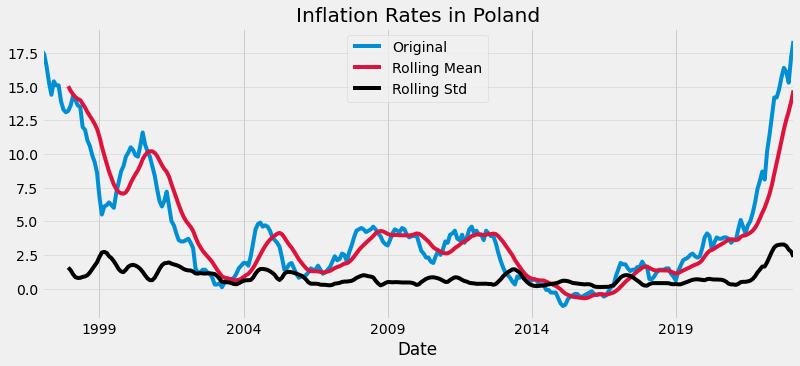

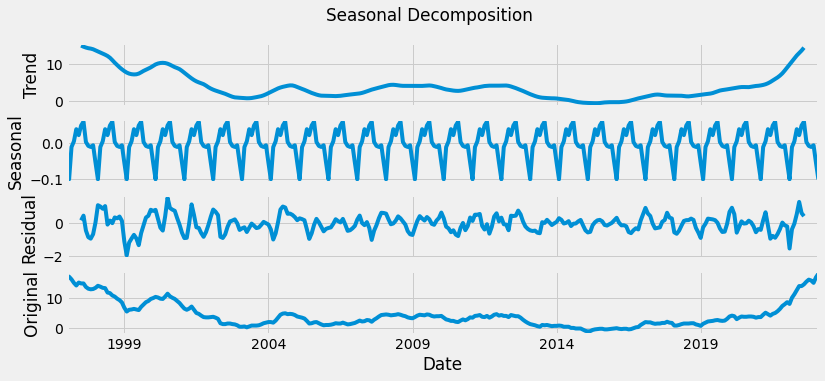

In [2]:
# visualize target data
def plot_time_series(series):
    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()
    
    # plot inflation rates
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('Inflation Rates in Poland')
    plt.grid(axis='y', alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # plot decomposition components
    decomp = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')
    
    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')
    
    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')
    
    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')
    
    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

plot_time_series(df['Rate'])

* Inflation in Poland has lately an overall upward trend.
* The dataset does not contain outliers.
* We can spot negative values (deflation) from 2014 to 2017.
* There are no familiar patterns within the data. The data looks non-stationary.

For next step, we will implement the Augmented Dickey-Fuller unit root test for data stationarity lookup. We would like to see the p-value of the test be smaller than 0.05 because this means the residuals for our time series model are independent. We also except the ADF result to be less than 5% of critical value - in other words with 95% confidence. This is often an assumption made when creating a SARIMA model.

In [3]:
# ADF statistical test
def adf_test(series):
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return

# run function
adf_test(df['Rate'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: -2.197475
2. P-value: 0.207163
3. Used Lags: 13
4. Used Observations: 300
5. Critical Values:
	1%: -3.452337
	5%: -2.871223
	10%: -2.571929

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


The statistical test exhibits p-value = 0.2072 is greater than 0.05 and the data is non-stationary. We need to perform data transformation or adjusting to make the data more stationary. This action will optimize model validation.

### 2. Stationarizing Series

The p-value should be as small as possible. Some examples of series transformation include:
* logarithm,
* power transformations (Box-Cox, Yeo-Johnson, etc.),
* differencing (seasonal, n-th order differencing).

Power transformations are parametric and make data more Gaussian-like (normalized). Differencing are the most common used techniques for autoregressive modelling. Plotting ACF and PACF graphs can help us choose the best transformation by observing patterns and lags. They are also useful for determining the the ranges of components in the orders.

In [4]:
# perform data transformation
# series: must be a pandas dataframe
def series_transformation(series):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller
    
    # 1st plot - data after transformation
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Transformed Series')
    ax1.plot(series)
    ax1.plot(series.rolling(window=12).mean(), color='crimson')
    ax1.plot(series.rolling(window=12).std(), color='black')
    
    # 2nd plot - partial autocorrelation plot
    ax2 = fig.add_subplot(1, 3, 2)
    plot_acf(series.dropna(), ax=ax2, lags=50, title='Autocorrelation')
    # plot 95% confidence intervals
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    
    # 3rd plot - partial autocorrelation plot
    ax3 = fig.add_subplot(1, 3, 3)
    plot_pacf(series.dropna(), ax=ax3, lags=50, title='Partial Autocorrelation')
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    plt.show()
    
    # ADF test
    result = adfuller(series.dropna(), regression='c', autolag='AIC')
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('P-value = {:.6f}, the series is likely stationary.'.format(result[1]))
    else:
        print('P-value = {:.6f}, the series is likely non-stationary.'.format(result[1]))
    return

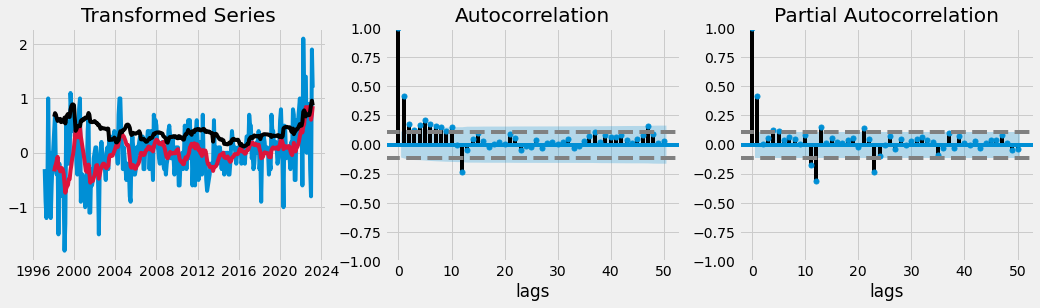

P-value = 0.001204, the series is likely stationary.


In [5]:
# first difference
series_transformation(df.diff())

The first difference time series shows less trend anymore. It looks to be more stationary. We will try further differencing.

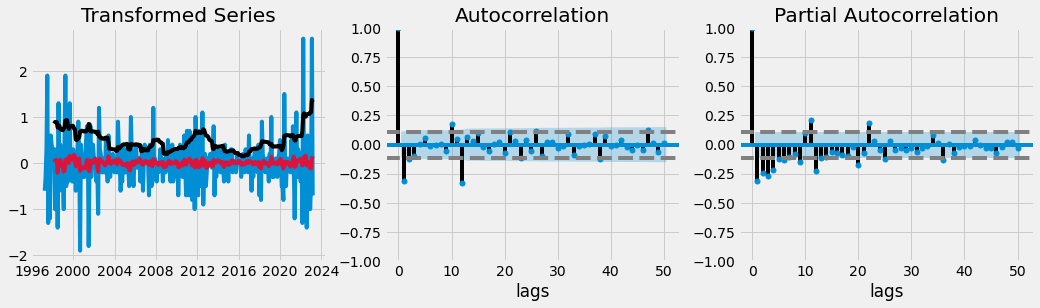

P-value = 0.000000, the series is likely stationary.


In [6]:
# second difference
series_transformation(df.diff().diff())

The second difference time series doesn’t show a strong trend anymore. The first lag autocorrelation is negative and the ACF plot is patternless. The series likely does not need a higher order of differencing. The first lag autocorrelation did not reach -0.5 and the series should not be over-differenced. Implementing another differencing order will increase the standard deviation and series will over-difference, which can result in additional complexity.

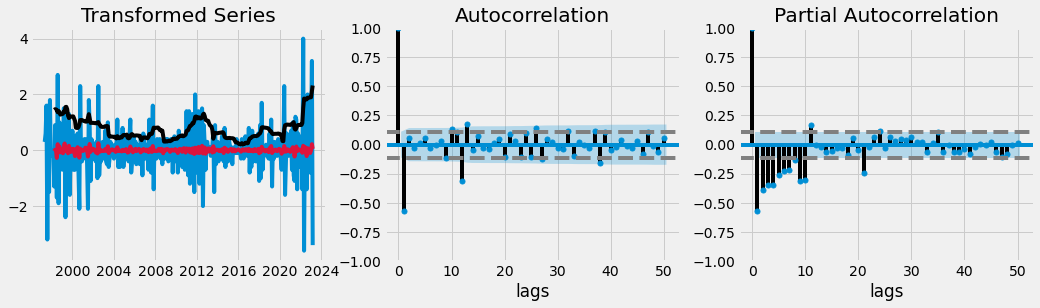

P-value = 0.000000, the series is likely stationary.


In [7]:
# third difference
series_transformation(df.diff().diff().diff())

This time we might spot over-differencing. The first lag autocorrelation reached below -0.5. The number of negative lags in PACF keeps increasing with each order. The standard deviation increased. These are all signs of over-differencing. The <code>d</code> component in trend order will be likely 2.

### 3. Find Optimal SARIMA Configuration

To forecast future rates, we will implement the SARIMA algorithm from <code>statsmodels</code> library which is an extension of the ARIMA. This model explicitly supports univariate time series data with an additional seasonal component.

The SARIMA contains main hyperparameters for <code>(p, d, q)</code> trend order and <code>(P, D, Q, m)</code> seasonality order. The <code>m</code> in the seasonality order indicates the periodicity, i.e. the number of periods in season, such as 4 for quarterly data, 12 for monthly data, 24 for hourly or 365 for daily data. In this case <code>m</code> will obviously be equal 12.

We will develop a function checking scores for each possible SARIMA orders in a grid search approach. The best performance and goodness of fit will be determined by the AIC (Akaike Information Critera). It is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. AIC can only be used to compare ARIMA models with the same orders of differencing. For ARIMAs with different orders of differencing, RMSE can be used for model comparison.

In [8]:
# find best orders and evaluate each combination for SARIMAX model
# series: must be a pandas dataframe
def find_optimal_orders(series, verbose=True):
    # filter out harmless warnings
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import time
    
    # start timer
    start_time = time.time()
    
    ######### list of possible combinations
    order_list = []
    for p in range(0, 3):
            for d in range(0, 2):
                for q in range(0, 3):
                    order_list.append((p, d, q))
    
    ######### initialize variables
    m = 12
    trend_pdq = order_list
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in order_list]
    min_aic = float('inf')
    best_params = {'order': None, 'seasonal_order': None}
    
    ######### loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(trend_pdq) * len(trend_pdq)))
    print('========== SARIMAX Results ==========\n')
    count = 0
    for param in trend_pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(endog=series, order=param, seasonal_order=param_seasonal, freq='M', exog=None,
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                
                if verbose:
                    count += 1
                    print('{}. SARIMAX{}{}[{}],\tAIC = {:.6f},\tBIC = {:.6f}'.format(count, param,
                                                        param_seasonal[:-1], m, model_fit.aic, model_fit.bic))
                    
                if model_fit.aic < min_aic:
                    min_aic = model_fit.aic
                    best_params['order'] = param
                    best_params['seasonal_order'] = param_seasonal
                    line = count
            except:
                print('Error while fitting model')
                continue
    print('\nBest order: {}{}[{}] with AIC = {:.6f} at line {}'.format(best_params['order'],
                                                             best_params['seasonal_order'][:-1], m, min_aic, line))
    
    # stop timer and display execution time
    diff = time.time() - start_time
    print('\n(Total time of execution: {:.0f} min {:.2f} s)'.format(diff%3600//60, diff%60))

In [9]:
# display results
find_optimal_orders(df['Rate'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 2007.175687,	BIC = 2010.921890
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 1709.783854,	BIC = 1717.198075
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 1502.544040,	BIC = 1513.543320
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 1524.196463,	BIC = 1527.903573
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 1458.973849,	BIC = 1466.306702
6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 1373.397441,	BIC = 1384.269494
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 1505.586366,	BIC = 1513.007220
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 1502.504631,	BIC = 1513.625962
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 1451.311580,	BIC = 1465.977287
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 1467.740342,	BIC = 1475.080104
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 1448.694359,	BIC = 1459.693639
12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 1356.176772,	BIC = 1370.672842
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 1456.399482,	BIC = 1467.409125
14. SARIMAX(0, 

116. SARIMAX(1, 0, 0)(1, 0, 1)[12],	AIC = 418.933211,	BIC = 433.761652
117. SARIMAX(1, 0, 0)(1, 0, 2)[12],	AIC = 363.131523,	BIC = 381.463657
118. SARIMAX(1, 0, 0)(1, 1, 0)[12],	AIC = 523.662919,	BIC = 534.662199
119. SARIMAX(1, 0, 0)(1, 1, 1)[12],	AIC = 431.750420,	BIC = 446.416126
120. SARIMAX(1, 0, 0)(1, 1, 2)[12],	AIC = 385.060603,	BIC = 403.180690
121. SARIMAX(1, 0, 0)(2, 0, 0)[12],	AIC = 362.432465,	BIC = 377.098172
122. SARIMAX(1, 0, 0)(2, 0, 1)[12],	AIC = 363.169892,	BIC = 381.502026
123. SARIMAX(1, 0, 0)(2, 0, 2)[12],	AIC = 354.831718,	BIC = 376.830278
124. SARIMAX(1, 0, 0)(2, 1, 0)[12],	AIC = 407.318748,	BIC = 421.814818
125. SARIMAX(1, 0, 0)(2, 1, 1)[12],	AIC = 379.382341,	BIC = 397.502429
126. SARIMAX(1, 0, 0)(2, 1, 2)[12],	AIC = 368.420422,	BIC = 390.164527
127. SARIMAX(1, 0, 1)(0, 0, 0)[12],	AIC = 416.852753,	BIC = 428.081763
128. SARIMAX(1, 0, 1)(0, 0, 1)[12],	AIC = 388.717006,	BIC = 403.532136
129. SARIMAX(1, 0, 1)(0, 0, 2)[12],	AIC = 312.930030,	BIC = 331.244832
130. S

232. SARIMAX(2, 0, 0)(2, 1, 0)[12],	AIC = 362.290710,	BIC = 380.392715
233. SARIMAX(2, 0, 0)(2, 1, 1)[12],	AIC = 324.294282,	BIC = 346.016687
234. SARIMAX(2, 0, 0)(2, 1, 2)[12],	AIC = 325.466187,	BIC = 350.808993
235. SARIMAX(2, 0, 1)(0, 0, 0)[12],	AIC = 408.432986,	BIC = 423.404999
236. SARIMAX(2, 0, 1)(0, 0, 1)[12],	AIC = 385.702378,	BIC = 404.221290
237. SARIMAX(2, 0, 1)(0, 0, 2)[12],	AIC = 290.500384,	BIC = 312.478147
238. SARIMAX(2, 0, 1)(0, 1, 0)[12],	AIC = 646.045652,	BIC = 660.860782
239. SARIMAX(2, 0, 1)(0, 1, 1)[12],	AIC = 389.178059,	BIC = 407.492862
240. SARIMAX(2, 0, 1)(0, 1, 2)[12],	AIC = 373.335920,	BIC = 395.058325
241. SARIMAX(2, 0, 1)(1, 0, 0)[12],	AIC = 331.693787,	BIC = 350.212699
242. SARIMAX(2, 0, 1)(1, 0, 1)[12],	AIC = 340.373880,	BIC = 362.596575
243. SARIMAX(2, 0, 1)(1, 0, 2)[12],	AIC = 299.886217,	BIC = 325.526940
244. SARIMAX(2, 0, 1)(1, 1, 0)[12],	AIC = 454.448779,	BIC = 472.763581
245. SARIMAX(2, 0, 1)(1, 1, 1)[12],	AIC = 361.452615,	BIC = 383.430378
246. S

The function returned the optimal hyperparameters to implement in the final model.

### 4. Developing SARIMA Model

We will start by forecasting and visualizing the future inflation rates. Next step, we will plot diagnostics and calculate some evaluation scores to judge the performance of our model.

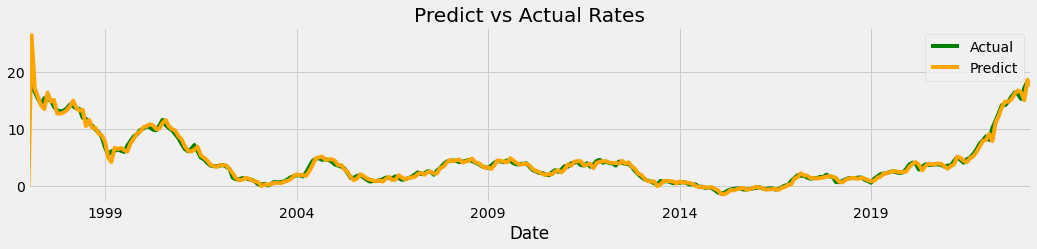

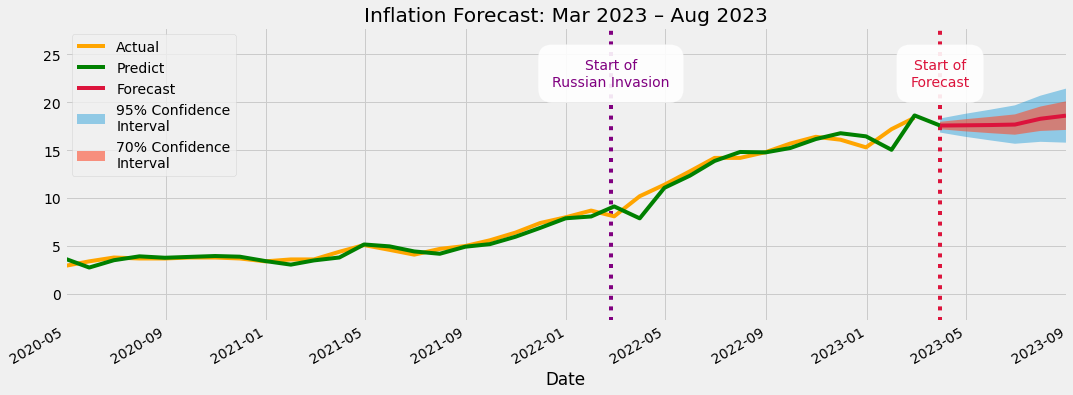

,Forecast [%]
2023-03-31,17.6
2023-04-30,17.6
2023-05-31,17.6
2023-06-30,17.7
2023-07-31,18.3
2023-08-31,18.6


In [10]:
# SARIMA model visualization
def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    # develop model
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='M', exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # predictions (from 0 to February 2023)
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False).rename('Predict')

    # forecast and confidence intervals 70% and 95%
    conf_int_70 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.3)
    conf_int_95 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.05)
    
    # extract index list
    def index_list():
        conf_interval = conf_int_95.reset_index()
        return conf_interval['index'].to_list()

    indx_list = index_list()
    
    # 1st plot - actual vs predict rates
    series.plot(legend=True, label='Actual', figsize=(16, 3), color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Predict vs Actual Rates')
    plt.legend()
    plt.show()
    
    # list of events to plot
    event_list = [(pd.to_datetime('2022-02-24'), 'Start of\nRussian Invasion', 'purple'),
                  (pd.to_datetime('2023-03-31'), 'Start of\nForecast', 'crimson')]
    
    # plot events
    for date_point, label, clr in event_list:
        plt.axvline(x=date_point, color=clr, linestyle=':')
        plt.text(x=date_point, y=23, s=label, horizontalalignment='center', verticalalignment='center',
                 color=clr, bbox=dict(facecolor='white', alpha=0.9, boxstyle='round, pad=1', linewidth=0.2))

    # 2nd plot - forecasting results
    series.plot(legend=True, label='Actual', figsize=(16, 6), color='orange')
    yhat.plot(legend=True, color='green')
    conf_int_95['mean'].plot(legend=True, label='Forecast', color='crimson')
    # confidence intervals 95%
    plt.fill_between(x=indx_list, y1=conf_int_95['mean_ci_upper'], y2=conf_int_95['mean_ci_lower'],
                     alpha=0.4, label='95% Confidence\nInterval', linewidth=0)
    # confidence intervals 70%
    plt.fill_between(x=indx_list, y1=conf_int_70['mean_ci_upper'], y2=conf_int_70['mean_ci_lower'],
                     alpha=0.6, label='70% Confidence\nInterval', linewidth=0)
    plt.xlim(['2020-05', '2023-09'])
    plt.title('Inflation Forecast: Mar 2023 – Aug 2023')
    plt.legend(loc='upper left')
    plt.show()
    
    # display forecasted rates
    return pd.DataFrame(round(conf_int_95['mean'], 1)).rename({'mean': 'Forecast [%]'}, axis=1)

# plot SARIMA results
forecast_SARIMA(series=df['Rate'], order=(1, 1, 2), seasonal_order=(0, 0, 2, 12))

* The predict spline is fitted to the actual with high accuracy. There are high differences only at the beginning of time series.
* Contrary to what the ruling party says, the Russian invasion of Ukraine did not affect Polish inflation significantly. There are no visible changes in trend.

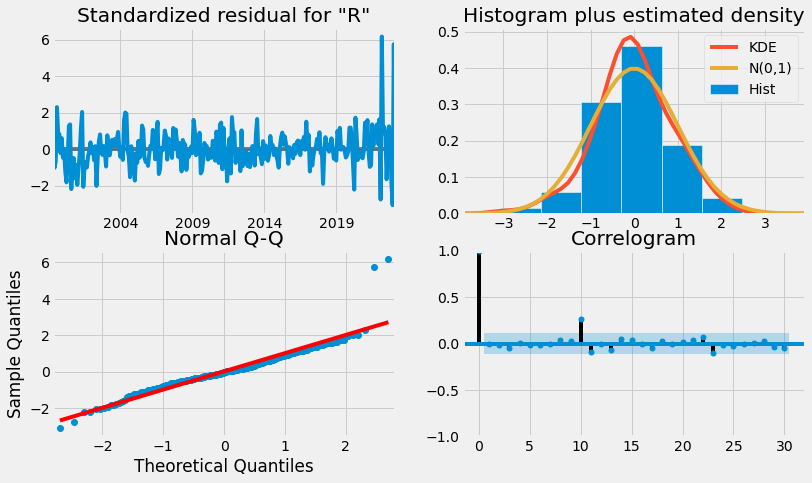

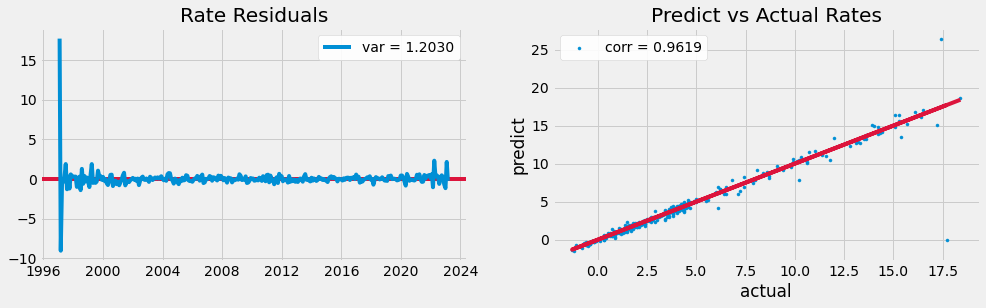

Metric,AIC,BIC,HQIC,RMSE,MAE,MAPE
,268.774205,290.710156,277.566791,1.203532,0.385299,0.152215


In [11]:
# SARIMA model evaluation
def evaluate_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    # develop model
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='M', exog=None,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # predictions
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False)
    
    ######### evaluation scores
    rmse = np.mean((series - yhat[:-1])**2)**0.5
    mae = np.mean(np.abs(series - yhat[:-1]))
    mape = np.mean(np.abs(series - yhat[:-1])/np.abs(series))
    var = np.std(model_fit.resid.values)
    corr = np.corrcoef(series, yhat[:-1])[0, 1]
    
    metric_list = ['AIC', 'BIC', 'HQIC', 'RMSE', 'MAE', 'MAPE']
    value_list = [model_fit.aic, model_fit.bic, model_fit.hqic, rmse, mae, mape]
 
    # 1st plot - diagnostics
    model_fit.plot_diagnostics(lags=30, figsize=(12, 7))
    plt.show()
    
    # 2nd plot - residuals
    fig = plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.axhline(0, color='crimson')
    plt.plot(model_fit.resid, label='var = {:.4f}'.format(var))
    plt.title('Rate Residuals')
    plt.legend(facecolor='white', framealpha=0.9)
    
    # 3rd plot - actual vs predict rates
    plt.subplot(1, 2, 2)
    plt.plot(df['Rate'], df['Rate'], color='crimson')
    plt.scatter(x=df['Rate'], y=yhat[:-1], marker='.', label='corr = {:.4f}'.format(corr))
    plt.title('Predict vs Actual Rates')
    plt.xlabel('actual')
    plt.ylabel('predict')
    plt.legend(facecolor='white', framealpha=0.9)
    plt.show()

    # display evaluation scores
    return pd.DataFrame(zip(metric_list, value_list), columns=['Metric', '']).set_index('Metric').T

# model evaluation
evaluate_SARIMA(series=df['Rate'], order=(1, 1, 2), seasonal_order=(0, 0, 2, 12))

**Diagnostics plots**
* The standardized residuals appear to be white noise.
* The residuals on the histogram follow quite close the standard normal distribution with positive skewness.
* The Q–Q plot (quantile-quantile plot) displays marker deviation upon the second quartiles (median values). In general, the markers are aligned quite good on the red line.
* The correlogram shows no significant autocorrelations for residual errors. Any autocorrelation would suggest that there is some pattern in the residual which are not explained in the model.

**Bottom plots**
* The residuals are plotted chronologically without any transformations. They seem to fluctuate around a mean of zero. Again, we can see highest residuals at the beginning of time series. The variance describes the dispersion, how far the set of residuals is spread out from their average value.
* Bottom right plot compares predicted rates with actual values. There is very strong correlation between these two features meaning that the inflation rates were predicted accurately.

### 5. Conclusion

We forecasted inflation rates with autoregressive modelling. Inflation in Poland will flatten out or continue to slightly increase. We should still expect higher prices in the market over the next few months.

Using the SARIMA model, we can forecast and analyze a time series using the series past inflation rates. It only requires the prior (historical) data of a time series to generalize the forecast which is a great advantage. No additional coefficients are needed to include for the validation process.

Owing to classical statistics and purely statistical methodology, autoregressive models are considered relic but are easier to understand. They require lots of prior knowledge to use them successfully. They also involve lots of hyperparameter tuning, polishing, and computational to make them accurate. Therefore, they are insufficient for many modern applications and give way to deep learning. We need to keep in mind that the SARIMA method performances great for short term forecasts. The model is used primarily for illustrative purposes and to know what to expect in the near future. Still, a SARIMA model can therefore be an attractive alternative.